In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
# 禁用科学计数法
pd.set_option('display.float_format',lambda x : '%.2f' % x)

#设置最多显示的行
pd.set_option('display.max_rows',2500) 
pd.set_option('display.max_columns',100)
#对matplotlib进行设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use('fivethirtyeight')

#解决负号显示不了的问题
plt.rcParams['axes.unicode_minus']=False

In [2]:
train = pd.read_csv('C:/Users/Administrator/input/train_new_use.csv')
test = pd.read_csv('C:/Users/Administrator/input/test_new_use.csv')

In [24]:
train.loc[train['速度'] > 1,'渔船ID'].value_counts()

4069    3249
401     1977
4924    1528
5522    1461
164     1139
        ... 
1156       1
1616       1
1424       1
6546       1
4813       1
Name: 渔船ID, Length: 6619, dtype: int64

Text(0, 0.5, 'Frequency')

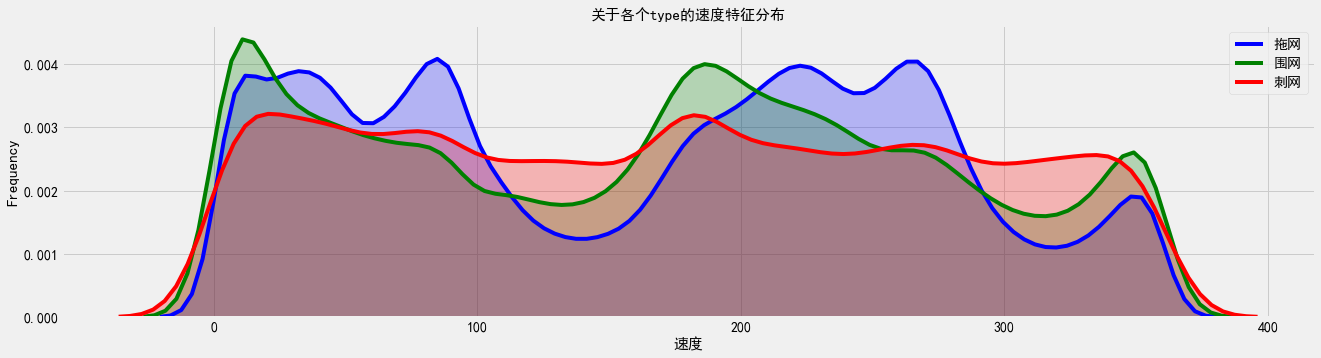

In [33]:
#开始特征工程
#先从特征衍生开始，创建出更多有用的特征
#先找找单变量的特征
#速度

f,ax = plt.subplots(figsize=(20,5))
sns.kdeplot(train.loc[(train['type']=='拖网') & (train['速度'] > 1) ,'方向'],color='b',shade=True,label='拖网')
sns.kdeplot(train.loc[(train['type']=='围网') & (train['速度'] > 1),'方向'],color='g',shade=True,label='围网')
sns.kdeplot(train.loc[(train['type']=='刺网')& (train['速度'] > 1),'方向'],color='r',shade=True,label='刺网')
#sns.distplot(train.loc[(train['type']=='围网') & (train['速度'] != 0),'方向'],kde=False,bins=36,color='r')
#sns.distplot(train.loc[(train['type']=='刺网') &(train['速度'] < 12),'速度'],kde=False,bins=12,color='b')
#sns.kdeplot(train.loc[:,'速度'],color = 'r',shade=True,label='所有')
plt.title('关于各个type的速度特征分布', fontsize = 15)
plt.xlabel("速度", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

In [34]:
features = []
for name,df in tqdm(train.groupby('渔船ID')):
    features.append([df['X'].std(), df['X'].mean(),df['X'].max(),df['X'].min(),df['X'].median(),
                             df['Y'].std(), df['Y'].mean(),df['Y'].max(),df['Y'].min(),df['Y'].median(),
                             df['速度'].std(), df['速度'].mean(), df['速度'].max(),df['速度'].min(),df['速度'].median(),
                             df['方向'].std(), df['方向'].mean(),df['方向'].max(),df['方向'].min(),df['方向'].median(),name,df['type'].iloc[0]])
test_df = pd.DataFrame(features)
df = test_df.rename(columns={0:'X_std',1:'X_mean',2:'X_max',3:'X_min',4:'X_median',
                               5:'Y_std',6:'Y_mean',7:'Y_max',8:'Y_min',9:'Y_median',
                                10:'sd_std',11:'sd_mean',12:'sd_max',13:'sd_min',14:'sd_median',
                                15:'fx_std',16:'fx_mean',17:'fx_max',18:'fx_min',19:'fx_median',20:'ID',21:'label'})
label_dict = {'拖网':0, '刺网':1, '围网':2}
df['label'] = df['label'].map(label_dict)

100%|██████████| 7000/7000 [00:22<00:00, 314.97it/s]


In [100]:
df

,X_std,X_mean,X_max,X_min,X_median,Y_std,Y_mean,Y_max,Y_min,Y_median,sd_std,sd_mean,sd_max,sd_min,sd_median,fx_std,fx_mean,fx_max,fx_min,fx_median,ID,label,sd/fx
0,5037.32,6119351.24,6152038.43,6118351.76,6118351.76,850.26,5130494.12,5130781.36,5124873.38,5130672.33,1.32,0.27,9.39,0.00,0.00,21.25,4.61,129,0,0.00,0,0,0.03
1,16543.39,6091460.39,6102449.88,6049471.87,6102449.88,26764.04,5094050.27,5112873.99,5042857.34,5112759.65,2.41,1.61,10.47,0.00,0.05,91.45,56.15,336,0,0.00,1,0,0.03
2,207.98,6183009.83,6183191.02,6182482.19,6183089.76,21.79,5193682.05,5193696.10,5193575.54,5193684.80,0.95,0.38,8.69,0.00,0.22,123.29,123.62,360,0,76.00,2,0,0.03
3,17503.71,5239159.28,5287804.94,5228590.20,5229842.64,11590.61,4601532.49,4608628.10,4577467.44,4608404.32,2.53,1.47,10.09,0.00,0.22,121.76,121.13,352,0,91.00,3,0,0.03
4,5979.58,7062005.25,7070796.58,7049394.10,7061678.85,12055.15,6116389.45,6136032.75,6094995.86,6116620.84,2.50,1.41,10.09,0.00,0.32,121.13,139.07,359,0,112.00,4,2,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,40883.81,6290574.51,6333177.42,6233906.33,6317374.06,33600.18,5207884.06,5251165.77,5150309.23,5200735.94,2.80,3.09,10.09,0.00,3.08,124.74,147.58,360,0,140.00,6995,0,0.03
6996,12954.78,6463526.66,6494481.66,6432284.33,6461638.84,15209.60,5460851.15,5494744.92,5432441.71,5460573.92,1.35,3.03,8.85,0.27,2.97,105.63,153.46,358,0,173.00,6996,2,0.03
6997,18138.25,5240221.68,5287462.08,5228700.46,5229842.64,12004.07,4600818.54,4608628.10,4577723.01,4608404.32,2.47,1.50,10.09,0.00,0.22,118.10,137.59,354,0,114.00,6997,0,0.03
6998,8459.67,6373425.39,6387624.89,6365019.74,6374702.19,25008.23,5395488.41,5423378.61,5343505.37,5415341.00,2.03,1.96,9.88,0.00,0.98,110.38,137.47,360,0,151.50,6998,0,0.03


Text(0, 0.5, 'Frequency')

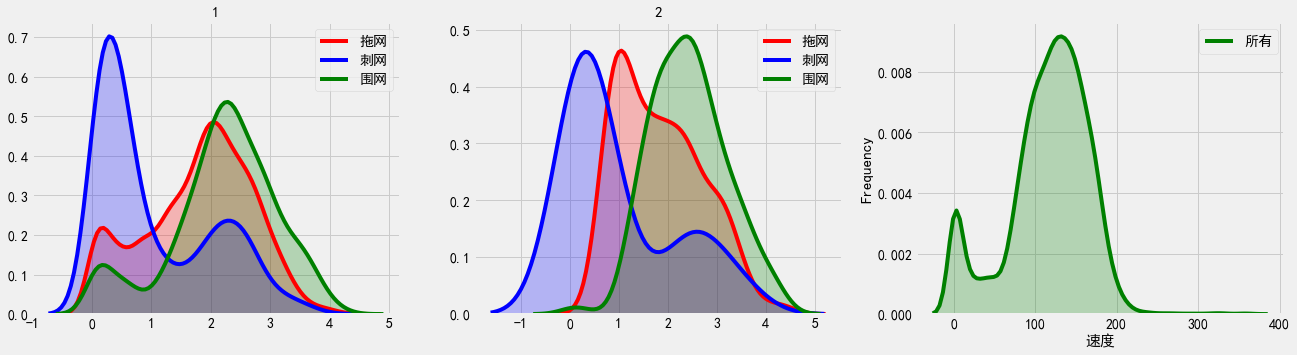

In [96]:
f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(20,5))
#sns.distplot(df.loc[(df['label']==0) ,'sd_std'],kde=False,color='g',label='拖网',ax=ax1)
sns.kdeplot(df.loc[(df['label']==0),'sd_std'],color = 'r',shade=True,ax=ax1,label='拖网')
sns.kdeplot(df.loc[(df['label']==1),'sd_std'],color = 'b',shade=True,ax=ax1,label='刺网')
sns.kdeplot(df.loc[(df['label']==2),'sd_std'],color = 'g',shade=True,ax=ax1,label='围网')
sns.kdeplot(df.loc[(df['label']==0)&(df['fx_mean']>180),'sd_std'],color = 'r',shade=True,ax=ax2,label='拖网')
sns.kdeplot(df.loc[(df['label']==1)&(df['fx_mean']>180),'sd_std'],color = 'b',shade=True,ax=ax2,label='刺网')
sns.kdeplot(df.loc[(df['label']==2)&(df['fx_mean']>180),'sd_std'],color = 'g',shade=True,ax=ax2,label='围网')

sns.kdeplot(df.loc[:,'fx_mean'],color = 'g',shade=True,ax=ax3,label='所有')
#sns.distplot(df.loc[(df['label']==1),'X_std'],kde=False,color='r',label='刺网')
#sns.distplot(df.loc[(df['label']==2),'X_std'],kde=False,color='b',label='围网')
#sns.distplot(train.loc[(train['type']=='围网') & (train['速度'] != 0),'方向'],kde=False,bins=36,color='r')
#sns.distplot(train.loc[(train['type']=='刺网') &(train['速度'] < 12),'速度'],kde=False,bins=12,color='b')
#sns.kdeplot(train.loc[:,'速度'],color = 'r',shade=True,label='所有')
ax1.set_title('1', fontsize = 15)
ax2.set_title('2', fontsize = 15)
plt.xlabel("速度", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

In [11]:
features_df = pd.DataFrame({'渔船ID':[i for i in range(7000)]})
features_df['XY_angle'] = 0.00

In [16]:
#1、渔船航行的角度（Y.max() - Y.min() / X.max() - X.min()） 如果分母为0，则返回0，表示不动渔船
for name,df in tqdm(train.groupby('渔船ID')):
    if df['X'].max() - df['X'].min() < 10:
        features_df.loc[features_df['渔船ID']==name,'XY_angle'] = 0.00
    else:
        features_df.loc[features_df['渔船ID']==name,'XY_angle'] = (df['Y'].max() - df['Y'].min()) / (df['X'].max() - df['X'].min())




100%|██████████| 7000/7000 [00:18<00:00, 387.30it/s]


In [33]:
#2、渔船从最后一条（也就是第一次信息）到最大X.max()的渔船信息的直线距离（x^2 + y^2 开方）
features_df['XY_space'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    X1,Y1 = df.iloc[-1,[1,2]]
    X2,Y2 = df.loc[df['速度']==df['速度'].max(),['X','Y']].iloc[0]
    space = np.sqrt((X2 - X1)**2 + (Y2 - Y1)**2)
    features_df.loc[features_df['渔船ID']==name,'XY_space'] = space

100%|██████████| 7000/7000 [00:28<00:00, 248.61it/s]


In [47]:
#3、渔船的位置的海域划分 
#做法: X低于560万的做聚类，560W-595W确定为拖网、595W-675W做聚类，大于675Ｗ归为围网。（这一行的都基于Y低于620W的）
#Y大于620W但小于640W的归为拖网、大于640W的都为围网（稍后再做）
train_N = train.drop_duplicates('渔船ID')
train_N.loc[(train_N['X'] < 6000000),'type'].value_counts()

拖网    275
围网     17
刺网     11
Name: type, dtype: int64

In [48]:
#4、渔船最后一条信息和第一条信息的直线距离
features_df['XY_first_last'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    X1,Y1 = df.iloc[-1,[1,2]]
    X2,Y2 = df.iloc[0,[1,2]]
    space = np.sqrt((X2 - X1)**2 + (Y2 - Y1)**2)
    features_df.loc[features_df['渔船ID']==name,'XY_first_last'] = space

100%|██████████| 7000/7000 [00:19<00:00, 357.64it/s]


In [49]:
#5、渔船sum(abs.dY) / sum(abs.dX) ，注意数据清洗
features_df['sum_dY/dX'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    result = abs(df['dY']).sum() / abs(df['dX']).sum()
    features_df.loc[features_df['渔船ID']==name,'sum_dY/dX'] = result

100%|██████████| 7000/7000 [00:17<00:00, 405.56it/s]


In [51]:
#6、渔船X.mean() / X.max()  还有 Y.mean / Y.max()
features_df['X_mean/max'] = 0.00
features_df['Y_mean/max'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'X_mean/max'] = df['X'].mean() / df['X'].max()
    features_df.loc[features_df['渔船ID']==name,'Y_mean/max'] = df['Y'].mean() / df['Y'].max()

100%|██████████| 7000/7000 [00:29<00:00, 240.42it/s]


In [52]:
#7、渔船X.mean() + Y.mean() / X.max() + Y.max()
features_df['XY_mean/max'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'XY_mean/max'] = (df['X'].mean() + df['Y'].mean())  / (df['X'].max() + df['Y'].max())

100%|██████████| 7000/7000 [00:17<00:00, 394.19it/s]


In [57]:
#8、dY 的75%  或者 dX的75% 其中一个就好
features_df['dX_90'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'dX_90'] = df['dX'].quantile(0.90)

100%|██████████| 7000/7000 [00:18<00:00, 371.92it/s]


In [55]:
#1、sd_std * fx_mean
features_df['sf_std_mean'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'sf_std_mean'] = df['速度'].std() * df['方向'].mean()

100%|██████████| 7000/7000 [00:16<00:00, 429.66it/s]


In [70]:
#2、速度小于1的比例
features_df['sd_small_1'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'sd_small_1'] = df.loc[(df['速度'] < 1)].shape[0] / df.shape[0]

100%|██████████| 7000/7000 [00:20<00:00, 343.15it/s]


In [73]:
#3、速度1-2在1-9中的比率，和速度2-6在1-9中的比率，和速度6-9在1-9比例
features_df['sd_rate_12'] = 0.00
features_df['sd_rate_26'] = 0.00
features_df['sd_rate_69'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    num_sd = df.loc[(df['速度'] > 1) & (df['速度'] < 9)].shape[0]
    if num_sd < 5:
        features_df.loc[features_df['渔船ID']==name,'sd_rate_12'] = 0.00
        features_df.loc[features_df['渔船ID']==name,'sd_rate_26'] = 0.00
        features_df.loc[features_df['渔船ID']==name,'sd_rate_69'] = 0.00
    else:
        features_df.loc[features_df['渔船ID']==name,'sd_rate_12'] = df.loc[(df['速度'] > 1) & (df['速度'] < 2)].shape[0] / num_sd
        features_df.loc[features_df['渔船ID']==name,'sd_rate_26'] = df.loc[(df['速度'] > 2) & (df['速度'] < 6)].shape[0] / num_sd
        features_df.loc[features_df['渔船ID']==name,'sd_rate_69'] = df.loc[(df['速度'] > 6) & (df['速度'] < 9)].shape[0] / num_sd
    
    
    

100%|██████████| 7000/7000 [01:12<00:00, 96.97it/s] 


In [76]:
#4、绝对值的方向变化的平均值
features_df['fx_change_mean'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'fx_change_mean'] = abs(df['方向变化']).mean()

100%|██████████| 7000/7000 [00:16<00:00, 425.56it/s]


In [78]:
features_df.to_csv('C:/Users/Administrator/input/train_features_new.csv',index=False)

In [84]:
#给测试集弄个


#注意这里的赋值
train = test
features_df = pd.DataFrame({'渔船ID':[i + 7000 for i in range(2000)]})
features_df['XY_angle'] = 0.00


#1、渔船航行的角度（Y.max() - Y.min() / X.max() - X.min()） 如果分母为0，则返回0，表示不动渔船
for name,df in tqdm(train.groupby('渔船ID')):
    if df['X'].max() - df['X'].min() < 10:
        features_df.loc[features_df['渔船ID']==name,'XY_angle'] = 0.00
    else:
        features_df.loc[features_df['渔船ID']==name,'XY_angle'] = (df['Y'].max() - df['Y'].min()) / (df['X'].max() - df['X'].min())
#2、渔船从最后一条（也就是第一次信息）到最大X.max()的渔船信息的直线距离（x^2 + y^2 开方）
features_df['XY_space'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    X1,Y1 = df.iloc[-1,[1,2]]
    X2,Y2 = df.loc[df['速度']==df['速度'].max(),['X','Y']].iloc[0]
    space = np.sqrt((X2 - X1)**2 + (Y2 - Y1)**2)
    features_df.loc[features_df['渔船ID']==name,'XY_space'] = space
#3、渔船的位置的海域划分 
#做法: X低于560万的做聚类，560W-595W确定为拖网、595W-675W做聚类，大于675Ｗ归为围网。（这一行的都基于Y低于620W的）
#Y大于620W但小于640W的归为拖网、大于640W的都为围网（稍后再做）
#train_N = train.drop_duplicates('渔船ID')
#train_N.loc[(train_N['X'] < 6000000),'type'].value_counts()

100%|██████████| 2000/2000 [00:44<00:00, 44.64it/s]


In [86]:
#4、渔船最后一条信息和第一条信息的直线距离
features_df['XY_first_last'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    X1,Y1 = df.iloc[-1,[1,2]]
    X2,Y2 = df.iloc[0,[1,2]]
    space = np.sqrt((X2 - X1)**2 + (Y2 - Y1)**2)
    features_df.loc[features_df['渔船ID']==name,'XY_first_last'] = space
#5、渔船sum(abs.dY) / sum(abs.dX) ，注意数据清洗
features_df['sum_dY/dX'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    result = abs(df['dY']).sum() / abs(df['dX']).sum()
    features_df.loc[features_df['渔船ID']==name,'sum_dY/dX'] = result
#6、渔船X.mean() / X.max()  还有 Y.mean / Y.max()
features_df['X_mean/max'] = 0.00
features_df['Y_mean/max'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'X_mean/max'] = df['X'].mean() / df['X'].max()
    features_df.loc[features_df['渔船ID']==name,'Y_mean/max'] = df['Y'].mean() / df['Y'].max()
#7、渔船X.mean() + Y.mean() / X.max() + Y.max()
features_df['XY_mean/max'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'XY_mean/max'] = (df['X'].mean() + df['Y'].mean())  / (df['X'].max() + df['Y'].max())
#8、dY 的75%  或者 dX的75% 其中一个就好
features_df['dX_90'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'dX_90'] = df['dX'].quantile(0.90)
#1、sd_std * fx_mean
features_df['sf_std_mean'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'sf_std_mean'] = df['速度'].std() * df['方向'].mean()
#2、速度小于1的比例
features_df['sd_small_1'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'sd_small_1'] = df.loc[(df['速度'] < 1)].shape[0] / df.shape[0]

100%|██████████| 2000/2000 [00:42<00:00, 46.96it/s]


In [87]:
#3、速度1-2在1-9中的比率，和速度2-6在1-9中的比率，和速度6-9在1-9比例
features_df['sd_rate_12'] = 0.00
features_df['sd_rate_26'] = 0.00
features_df['sd_rate_69'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    num_sd = df.loc[(df['速度'] > 1) & (df['速度'] < 9)].shape[0]
    if num_sd < 5:
        features_df.loc[features_df['渔船ID']==name,'sd_rate_12'] = 0.00
        features_df.loc[features_df['渔船ID']==name,'sd_rate_26'] = 0.00
        features_df.loc[features_df['渔船ID']==name,'sd_rate_69'] = 0.00
    else:
        features_df.loc[features_df['渔船ID']==name,'sd_rate_12'] = df.loc[(df['速度'] > 1) & (df['速度'] < 2)].shape[0] / num_sd
        features_df.loc[features_df['渔船ID']==name,'sd_rate_26'] = df.loc[(df['速度'] > 2) & (df['速度'] < 6)].shape[0] / num_sd
        features_df.loc[features_df['渔船ID']==name,'sd_rate_69'] = df.loc[(df['速度'] > 6) & (df['速度'] < 9)].shape[0] / num_sd
#4、绝对值的方向变化的平均值
features_df['fx_change_mean'] = 0.00
for name,df in tqdm(train.groupby('渔船ID')):
    features_df.loc[features_df['渔船ID']==name,'fx_change_mean'] = abs(df['方向变化']).mean()

100%|██████████| 2000/2000 [00:40<00:00, 49.68it/s]


In [88]:
features_df

,渔船ID,XY_angle,XY_space,XY_first_last,sum_dY/dX,X_mean/max,Y_mean/max,XY_mean/max,dX_90,sf_std_mean,sd_small_1,sd_rate_12,sd_rate_26,sd_rate_69,fx_change_mean
0,7000,1.47,64102.21,69064.16,1.00,1.00,0.99,0.99,835.46,397.20,0.76,0.08,0.41,0.51,109.01
1,7001,1.70,15484.66,15690.83,1.50,1.00,0.99,1.00,905.07,346.16,0.21,0.17,0.78,0.04,55.71
2,7002,1.02,129722.26,252378.15,0.83,0.99,0.98,0.99,1579.90,409.32,0.28,0.30,0.48,0.20,68.79
3,7003,0.57,109.31,149.38,0.65,0.99,1.00,1.00,101.16,328.24,0.86,0.21,0.26,0.53,98.40
4,7004,1.07,19760.71,26877.30,1.13,0.99,1.00,1.00,1.39,336.42,0.73,0.20,0.62,0.17,95.31
5,7005,1.10,0.00,0.00,1.07,1.00,1.00,1.00,0.00,26.86,0.98,0.50,0.50,0.00,90.43
6,7006,2.98,9525.07,37931.31,4.94,1.00,0.99,1.00,233.15,182.13,0.03,0.06,0.90,0.03,58.74
7,7007,1.38,51063.18,66391.22,0.89,1.00,0.99,0.99,1038.06,253.03,0.33,0.03,0.91,0.06,23.95
8,7008,0.19,9662.95,11168.52,0.20,1.00,1.00,1.00,100.44,86.05,0.96,0.67,0.11,0.22,99.19
9,7009,5.05,18062.99,31604.32,3.86,1.00,1.00,1.00,90.43,141.42,0.45,0.46,0.44,0.01,102.94


In [89]:
features_df.to_csv('C:/Users/Administrator/input/test_features_new.csv',index=False)

In [41]:
sum = []
for name,df in tqdm(train.groupby('渔船ID')):
    if df.loc[(train['速度'] > 11),'速度'].shape[0] > 0:
        sum.append(df.iloc[0])
    

100%|██████████| 7000/7000 [00:29<00:00, 238.22it/s]


In [51]:
test_df = pd.DataFrame(sum)

In [52]:
test_df.loc[:,'type'].value_counts()

围网    113
拖网     65
刺网      2
Name: type, dtype: int64

In [3]:
train_1 = train[train['type']=='围网']
small_sd = train_1.loc[(train_1['速度'] > 1) & (train_1['速度'] < 2) ,'速度'].shape[0] 
median_sd = train_1.loc[(train_1['速度'] > 2) & (train_1['速度'] < 6) ,'速度'].shape[0]
high_sd = train_1.loc[(train_1['速度'] > 6) & (train_1['速度'] < 9) ,'速度'].shape[0] 
print(small_sd,median_sd,high_sd)

def choice_sd(df):
    small_sd = df.loc[(df['速度'] > 0.8) & (df['速度'] < 2) ,'速度'].shape[0] * 1.75
    median_sd = df.loc[(df['速度'] > 2) & (df['速度'] < 6) ,'速度'].shape[0] 
    high_sd = df.loc[((df['速度'] > 6) & (df['速度'] < 10)) | (df['速度'] > 11) ,'速度'].shape[0] * 4
    if small_sd > median_sd:
        if small_sd > high_sd:
            return '刺网'
        else:
            return '围网'
    else:
        if median_sd > high_sd:
            return '拖网'
        elif median_sd < high_sd:
            return '围网'
        else:
            return 0 #这属于基本不动渔船
#注意;这里缺少判断不动的渔船（记得改）

45935 130084 45581


In [193]:
error_sd = []


for name,df in tqdm(train.groupby('渔船ID')):
    choice_result = choice_sd(df)
    if choice_result == df['type'].iloc[0]:
        result_true += 1
    elif choice_result == 0:
        result_no +=1
    else:
        error_sd.append(df['type'].iloc[0])
        result_False += 1
from collections import Counter
print(Counter(error_sd))

100%|██████████| 7000/7000 [00:28<00:00, 243.02it/s]

Counter({'拖网': 1760, '围网': 657, '刺网': 481})


In [170]:
result_true = 0
result_False = 0
result_no = 0

#ids = train.loc[:,'渔船ID'].unique()
#ids = [ids[np.random.randint(len(ids))] for x in range(3000)]
#train_2 = train[train['渔船ID'].isin(ids)]
for name,df in tqdm(train.groupby('渔船ID')):
    choice_result = choice_sd(df)
    if choice_result == df['type'].iloc[0]:
        result_true += 1
    elif choice_result == 0:
        result_no +=1
    else:
        result_False += 1
print('正确数为',result_true)
print('错误数为',result_False)
print('基本不动的',result_no)

100%|██████████| 7000/7000 [00:25<00:00, 279.05it/s]

正确数为 4048
错误数为 2627
基本不动的 325


In [194]:
train['work_sd'] = 0
for name,df in tqdm(train.groupby('渔船ID')):
    choice_result = choice_sd(df)
    if choice_result == '拖网':
        train.loc[train['渔船ID']==name,'work_sd'] = 1
    elif choice_result == '刺网':
        train.loc[train['渔船ID']==name,'work_sd'] = 2
    elif choice_result == '围网':
        train.loc[train['渔船ID']==name,'work_sd'] = 3
    else:
        train.loc[train['渔船ID']==name,'work_sd'] = 0


100%|██████████| 7000/7000 [11:01<00:00, 10.59it/s]


In [4]:
#给测试集弄个
test['work_sd'] = 0
for name,df in tqdm(test.groupby('渔船ID')):
    choice_result = choice_sd(df)
    if choice_result == '拖网':
        test.loc[test['渔船ID']==name,'work_sd'] = 1
    elif choice_result == '刺网':
        test.loc[test['渔船ID']==name,'work_sd'] = 2
    elif choice_result == '围网':
        test.loc[test['渔船ID']==name,'work_sd'] = 3
    else:
        test.loc[test['渔船ID']==name,'work_sd'] = 0

100%|██████████| 2000/2000 [01:02<00:00, 31.84it/s]


In [197]:
train_N = train.drop_duplicates('渔船ID')
train_N.loc[(train_N['type']=='刺网') & (train_N['work_sd'] != 2),'work_sd'].value_counts()

3    368
0    114
1    113
Name: work_sd, dtype: int64

In [5]:
test_work_sd = test.drop_duplicates('渔船ID')
test_work_sd = test_work_sd.loc[:,['渔船ID','work_sd']]
test_work_sd
test_work_sd.to_csv('C:/Users/Administrator/input/test_work_sd.csv',index=False)

In [200]:
test_work_sd = train.drop_duplicates('渔船ID')
test_work_sd = test_work_sd.loc[:,['渔船ID','work_sd']]
test_work_sd
test_work_sd.to_csv('C:/Users/Administrator/input/work_sd.csv',index=False)